## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Training model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping

# Performance metrics calculation support library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt

## Data preprocessing

### Read data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [4]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [5]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [6]:
#  Scaler data
scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [7]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(len(df_scaled) * 0.6)
val_size = int(len(df_scaled) * 0.2)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size : len(df_scaled), :]

## Model training and testing

In [8]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
# Add data for train, validation and test set
time_step = 30

val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [10]:
# Make input for DFNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

### Training process

#### Optimization

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

In [12]:
# Reshape x_train, x_test, x_val to 2 dimensions
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_val_2d = X_val.reshape(X_val.shape[0], -1)

In [13]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (256,), (128, 64), (64, 32, 16), (128, 64, 32)],
    'activation': ['relu'],
    'learning_rate': ['constant', 'adaptive'],
}

In [14]:
# Create the model
model = MLPRegressor()

In [15]:
# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)



In [16]:
# Find best params
best_val_mse = float('inf')
best_params = None

for hidden_layer_sizes in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for learning_rate in param_grid['learning_rate']:
            # Create the model
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, learning_rate=learning_rate,
                                 max_iter=10, batch_size=32)

            # Training with EarlyStopping
            es = EarlyStopping(patience=3, verbose=1)
            model.fit(X_train_2d, y_train)

            # Evaluate on validate sets
            train_predict=model.predict(X_train_2d)
            y_pred_val=model.predict(X_val_2d)

            #Inverse
            train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
            y_pred_val = scaler.inverse_transform(y_pred_val.reshape(-1, 1))
            y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

            val_mse = mean_squared_error(y_val, y_pred_val)

            # Update best model
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_params = {'hidden_layer_sizes': hidden_layer_sizes, 'activation': activation, 'learning_rate': learning_rate}



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py

In [17]:
# In kết quả
print("Best MSE:", best_val_mse)
print("Best Parameters:", best_params)


Best MSE: 42.03821919962947
Best Parameters: {'hidden_layer_sizes': (64,), 'activation': 'relu', 'learning_rate': 'constant'}


### Testing Processing

In [18]:
y_pred=model.predict(X_test_2d)

### Inverse

In [19]:
test_data = scaler.inverse_transform(test_data.reshape(-1, 1))

y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

ytest = scaler.inverse_transform(ytest.reshape(-1, 1))


### Evaluate Model

In [20]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.03806097653016197
Testing RMSE:  3.7061216654618625
Testing MSLE:  0.0023429235011934893


## Predicting the next 30 days

### Preparing the prediction data

In [21]:
x_input = test_data_extended[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()


# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        x_input = x_input.reshape((x_input.shape[0], x_input.shape[1]))

        y_hat = model.predict(x_input)

        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat.tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [22]:
# Print predict next 30 days
print(prediction_next30_days)

[0.38847080735088163, 0.38872754213175625, 0.3875909377108577, 0.386850786188584, 0.38809070697303, 0.38967448003190036, 0.3897774783568227, 0.39442607637548416, 0.39896162507646465, 0.4024650241775019, 0.40328969402579423, 0.40430749811367944, 0.40577786369427066, 0.40508654587521525, 0.40017038968510515, 0.3955207243528707, 0.3937608733186328, 0.39398890754699173, 0.39385095330456293, 0.3972223881812646, 0.4023958907176029, 0.4051326154576173, 0.4069949520074057, 0.41098609022546145, 0.41390343126783374, 0.4145221574237628, 0.41556773432258415, 0.4171068682527546, 0.4182300892148559, 0.4187372060446853]


### Preparing the forecast date index

In [23]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [24]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days.reshape(-1,1))

## Visualization

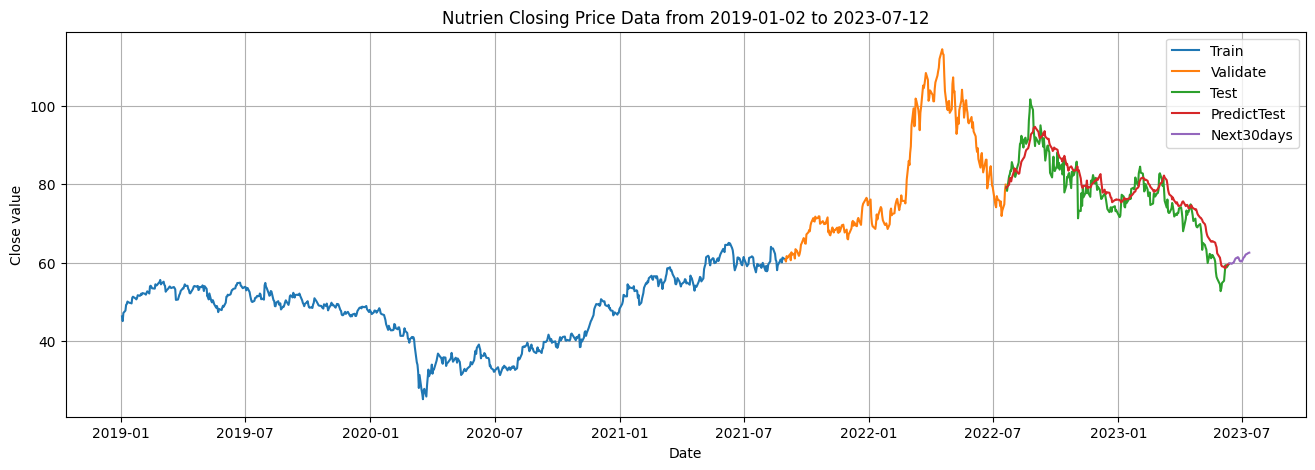

In [25]:
# Visualization
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], test_data)
plt.plot(df.index[train_size + val_size : ], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.legend(['Train','Validate','Test','PredictTest','Next30days'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from 2019-01-02 to 2023-07-12")
plt.xlabel("Date")
plt.ylabel("Close value")
#plt.savefig('../Image/DFNN_622_NTR.png')
plt.show()